# Babysitting the Learning Process with TensorBoard

Even with TensorFlow's built in Estimators, there are a huge number of hyperparameters to tune and tweak. This is the black magic part of neural networks. Sometimes things just work, and there's no great analytical reason why. This makes it really key for us to be able to sit on top on the model as it learns.

TensorFlow provides [TensorBoard](https://www.tensorflow.org/get_started/summaries_and_tensorboard), a visualization layer on top of the training process. 

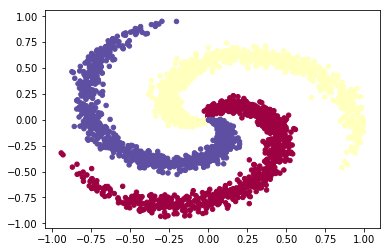

In [1]:
# We really like this spiral dataset

import numpy as np
import matplotlib.pyplot as plt

N = 1000 # points per class
D = 2 # dimensionality at 2 so we can eyeball it
K = 3 # number of classes

X = np.zeros((N*K, D)) # generate an empty matrix to hold X features
y = np.zeros(N*K, dtype='int32') # switching this to int32 

# for 3 classes, evenly generates spiral arms
for j in range(K):
    ix = range(N*j, N*(j+1))
    r = np.linspace(0.0,1,N) #radius
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap=plt.cm.Spectral)
plt.show()

## A much more highly optimized DNNClassifier

We repeat the setup in our old notebook

In [2]:
import tensorflow as tf

# what should the classifier expect in terms of features
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=D)]

# defining the actual classifier 
dnn_spiral_classifier = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                            activation_fn = tf.nn.relu, 
                                            hidden_units = [20,10],  # one hidden layer, containing 10 neurons
                                            n_classes = K, # K target classes 
                                            model_dir="/tmp/spiral_model_learning") # directory for saving model checkpoints

# turn data into tensors to feed into the computational graph
# honestly input_fn could also handle these as np.arrays but this is here to show you that the tf.constant operation can run on np.array input
def get_inputs(): 
  X_tensor = tf.constant(X)
  y_tensor = tf.constant(y)
  return X_tensor, y_tensor


# fit the model
dnn_spiral_classifier.fit(input_fn=get_inputs, steps=50)

#evaluating the accuracy 
accuracy_score = dnn_spiral_classifier.evaluate(input_fn=get_inputs, 
                                               steps=1)["accuracy"]

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x114aa2810>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 3151 into /tmp/spiral_model_

## Launching TensorBoard

We'll share a quick two liner that allows you to get your Tensorboard up and running so you can look around at its features.

In [3]:
from google.datalab.ml import TensorBoard
tb_id = TensorBoard.start("/tmp/spiral_model_learning")

TensorBoard was started successfully with pid 18475. Click here to access it.

Notice that the accuracy only contains one point. That's because we only ran `dnn_spiral_classifier.fit` and `evaluate` once and didn't tell it to record data during intermediary steps.

**WARNING: If you try it out on local...**  
... the link leads to a 404. It will lead you to an address like http://localhost:8888/_proxy/123 . You can access your Tensorboard using the port number at the end, e.g. http://localhost:123/ 


## Adding points

We create some more points by looping over the fitting. This creates ten more points.

In [4]:
# (optional) restrict logging level to errors, to keep things a little quieter
tf.logging.set_verbosity(tf.logging.ERROR)

for epoch in range(10):
    dnn_spiral_classifier.fit(input_fn=get_inputs, steps=100)
    dnn_spiral_classifier.evaluate(input_fn=get_inputs, steps=1)["accuracy"]

Refresh your Tensorboard to see the additional points.

**If you don't see any changes,** clear the cache or reopen in an incognito window. 

The full multi-step logging setup is available in the [official docs](https://www.tensorflow.org/get_started/summaries_and_tensorboard). It was changing every few months at the time this tutorial was created, so we chose not to go into detail for this section.

In [5]:
# The following line will wipe your tmp records if you want to "reset" everything while configuring your Tensorboard. Use it with caution!
do_I_want_to_reset = False
if do_I_want_to_reset:
    tf.gfile.DeleteRecursively('/tmp/spiral_model_learning/')